# Problem 1
## Part a)
Here, we use numpy to generate N=10000 random points from a uniform distribution from -1 to 1, then we calculate measured x and y, x by adding random gaussian error, and y by multiplying by  0.5 then adding new gaussian error. We plot the generated measurements, along with the "true" data as a line.

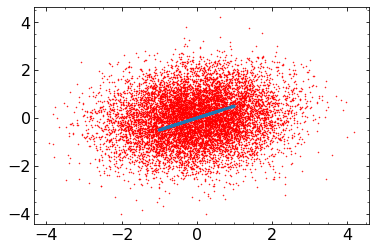

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin

plt.style.use('phys240.mplstyle')

N = 10000
sigma = 1
a_real = 0.5
z_i = np.random.rand(N) * 2 - 1

x_i = z_i + np.random.randn(N) * sigma
y_i = z_i * a_real + np.random.randn(N) * sigma

plt.scatter(x_i,y_i, c='r', marker='.',s=1)
plt.plot(z_i,z_i*a_real)

# Part b)
Here, we calculate chi-squared and find the minimum:  

$$\chi^2=\sum_i \frac{\left(data_i - model_i\right)^2}{\sigma_i^2}$$  

Substituting in our fitting model $y_{pred,i} = a x_i$, and with all measurement sigmas being equal,  
$$\chi^2=\sum_i \frac{\left(y_i - a x_i\right)^2}{\sigma^2}$$  
Then,
$$\frac{d \chi^2}{d a} = \frac{-1}{\sigma^2}\sum_i 2\left(y_i - a x_i\right)x_i$$  
$$\frac{d \chi^2}{d a} = \frac{-2}{\sigma^2}\sum_i \left(x_i y_i - a x_i^2\right)$$  
Since at the minimum $\chi^2$ we will have our max likelihood, we find the best fit $a=\tilde{a}$ where $\frac{d \chi^2}{d a} = 0$:  
$$0 = \sum_i x_i y_i - \tilde{a} \sum_j x_j^2$$  
$$\tilde{a} = \frac{\sum_i x_i y_i}{\sum_j x_j^2}$$  

In [2]:
a_best = np.sum(x_i * y_i) / np.dot(x_i, x_i)
print("Best fit for a: {}".format(a_best))

Best fit for a: 0.11703840328780943


This is different from the actual value of a, 0.5, but we want to know what the expected error would be. Assuming that $\chi^2$ can be well approximated around $\tilde{a}$ with only going up to the quadratic term in $a$, we can use the formula:  
$$\sigma_a^2 = \left(\frac{1}{2}\left.\frac{d^2 \chi^2}{d a^2} \right|_{\tilde{a}}\right)^{-1}$$  
We calculate:  
$$\frac{d^2 \chi^2}{d a^2} = \frac{d}{d a}  \frac{-2}{\sigma^2}\sum_i \left(x_i y_i - a x_i^2\right)$$  
$$\frac{d^2 \chi^2}{d a^2} = \frac{2}{\sigma^2}\sum_i x_i^2$$  
$$\sigma_a^2 = \left(\frac{1}{\sigma^2} \sum_i x_i^2\right)^{-1}$$  
$$\sigma_a = \sigma \sqrt{\frac{1}{\sum_i x_i^2}}$$  
We compute the error, the expected sigma for measuring a, and how far off we were.

In [41]:
from scipy import special

sigma_a = sigma * np.sqrt(1/np.dot(x_i,x_i))
std_devs_off_a_from_first_fit = abs(a_best - a_real)/sigma_a
print("Expected standard deviation for a_best: {}".format(sigma_a))
print("The error was {}, so we are {} standard deviations from the true value.".format(a_best-a_real,std_devs_off_a_from_first_fit))
print("The gaussian probability of being that far off is approximately erfc({}/sqrt(2))={}".format(
    std_devs_off_a_from_first_fit,
    special.erfc(std_devs_off_a_from_first_fit)
))

Expected standard deviation for a_best: 0.008617033151282111
The error was -0.38296159671219054, so we are 44.442395658558006 standard deviations from the true value.
The gaussian probability of being that far off is approximately erfc(44.442395658558006/sqrt(2))=0.0


# Part c)
We define a new variable, $w = y - a x$, with variance $\sigma_w^2 = \sigma_y^2 + a^2 \sigma_x^2$. Then, we have chi-squared in terms of w (and a):  
$$\chi^2 (a,w)  = \sum_i \frac{\left(y_i - a x_i - w\right)^2}{\sigma_{y,i}^2 + a^2 \sigma_{x,i}^2}$$  

$$\chi^2 (a,w) = \sum_i \frac{\left(y_i - a x_i - w\right)^2}{\sigma_y^2 + a^2 \sigma_x^2}$$  
Minimizing in terms of $w$, we find $\frac{d \chi^2}{d w} = 0$:  
$$0 = \frac{d \chi^2}{d w} = \sum_{i=1}^N \frac{-2 \left(y_i - a x_i - w\right)}{\sigma_y^2 + a^2 \sigma_x^2}$$  
$$0 = \sum_{i=1}^N\left(y_i - a x_i\right) - \sum_{i=1}^N w$$  
$$w_{best}(a) = \frac{1}{N}\sum_{i=1}^N \left(y_i - a x_i\right)$$  
Calculating x squared where we plug in the most likely w for a given a:

In [42]:
def w_best(a_guess, xdata, ydata):
    return(1/N) *np.sum(ydata - a_guess * xdata)

def chi_squared(w_guess, a_guess,xdata,ydata,sigmax,sigmay):
    diff_amt = ydata - a_guess*xdata - w_guess
    return (1/(sigmay*sigmay+a_guess*a_guess*sigmax*sigmax)) * np.dot(diff_amt, diff_amt)

def chi_squared_with_minimized_w_err(a_guess,xdata,ydata,sigmax,sigmay):
    return chi_squared(w_best(a_guess,xdata,ydata), a_guess,xdata,ydata,sigmax,sigmay)

def chi_squared_with_xi_yi(a_guess):
    return chi_squared_with_minimized_w_err(a_guess,x_i,y_i,sigma,sigma)

best_a = fmin(chi_squared_with_xi_yi, 0.5)
print("Best fit a: {}".format(best_a[0]))
print("Chi squared/N: {}".format(chi_squared_with_xi_yi(best_a[0])/N))

Optimization terminated successfully.
         Current function value: 10068.883595
         Iterations: 10
         Function evaluations: 20
Best fit a: 0.4642578124999999
Chi squared/N: 1.0068883594607128


We see that if we increase number of data points the guess gets better:

In [43]:
N_big = 1000000
z_many = np.random.rand(N_big) * 2 - 1
x_many = z_many + np.random.randn(N_big) * sigma
y_many = z_many * a_real  + np.random.randn(N_big) * sigma
def chi_squared_with_xmany_ymany(a_guess):
    return chi_squared_with_minimized_w_err(a_guess,x_many,y_many,sigma,sigma)
best_a = fmin(chi_squared_with_xmany_ymany, 0.5)
print("Best fit a: {}".format(best_a[0]))
print("Chi squared/N: {}".format(chi_squared_with_xmany_ymany(best_a[0])/N_big))

Optimization terminated successfully.
         Current function value: 1000430.214452
         Iterations: 11
         Function evaluations: 22
Best fit a: 0.498974609375
Chi squared/N: 1.0004302144518316


But we see that if we overestimate $\sigma_x$ by 15% and underestimate $\sigma_y$ by 30%, we get a different a:

In [45]:
def chi_squared_with_xi_yi_and_wrong_errs(a_guess):
    return chi_squared_with_minimized_w_err(a_guess,x_i,y_i,sigma*1.15,sigma*0.7)

best_a = fmin(chi_squared_with_xi_yi_and_wrong_errs, 0.5)
print("Best fit a: {}".format(best_a[0]))
print("Chi squared/N: {}".format(chi_squared_with_xi_yi_and_wrong_errs(best_a[0])/N))

Optimization terminated successfully.
         Current function value: 9865.636797
         Iterations: 21
         Function evaluations: 42
Best fit a: 3.7856445312500075
Chi squared/N: 0.9865636797183966


Even though our value of $\chi^2$ per degree of freedom looks good, this isn't a good fit, because we made bad assumptions about error distributions.

# Part e)

Here, we generate new measurement data where $\sigma_{y,i}^2 = 1$, and $\sigma_{x,i}^2 = \left|z_i\right|$  
So, if we fit with $y = ax+w$, then our new variance ($\sigma_i^2$) is:  
$$\sigma_i^2 = \sigma_{y,i}^2 + a^2 \sigma_{x,i}^2 = 1 + a^2 \left|z_i\right|$$
But since we don't know the real value of $z_i$ from a measurement, we'll have to use $x_i$ instead when we calculate $\chi^2$:
$$\chi^2 = 1 + a^2 \left|x_i\right|$$  

Then, we have
$$\chi^2\left(a,w\right) = \sum_i \frac{\left(y_i - a x_i - w\right)^2}{1 + a^2 \left|x_i\right|}$$  
Minimize with respect to $w$ for a given $a$:  
$$0 = \frac{\partial \chi}{\partial w} = -2 \sum_i \frac{y_i - a x_i - w}{1 + a^2\left|x_i\right|}$$  
$$w \sum_i \frac{1}{1 + a^2\left|x_i\right|} = \sum_i \frac{y_i - a x_i}{1 + a^2\left|x_i\right|} $$  
$$ w = \frac{\sum_i \frac{y_i - a x_i}{1 + a^2\left|x_i\right|}}{\sum_i \frac{1}{1 + a^2\left|x_i\right|}} $$

In [9]:
znew = np.random.rand(N)*2 - 1
xnewnoise = np.random.normal(loc=0,scale=np.sqrt(np.abs(znew)),size=N)
ynewnoise = np.random.normal(loc=0,scale=1,size=N)
ynew = znew * 0.5 + ynewnoise
xnew = znew + xnewnoise

Best a: 74.02090209020902
Min chi squared: 6680.408197167923


Text(0, 0.5, '$\\chi^2$')

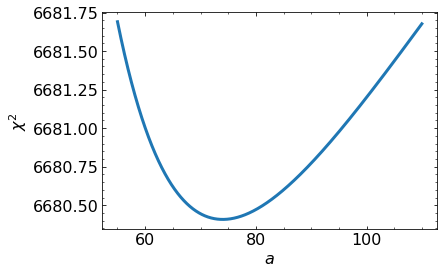

In [124]:

def chisquared_sigma_from_x(aguess):
    return np.sum(
        np.square(ynew - aguess * xnew) / (1. + aguess*aguess * np.abs(xnew))
    )

avals_sigma_from_x = list(np.linspace(55,110,10000))
chisquaredvals_sigma_from_x = [chisquared_sigma_from_x(aval) for aval in avals_sigma_from_x]

a_best_sigma_from_x = avals_sigma_from_x[np.argmin(chisquaredvals_sigma_from_x)]
print("Best a: {}".format(a_best_sigma_from_x))
print("Min chi squared: {}".format(min(chisquaredvals_sigma_from_x)))
plt.plot(avals_sigma_from_x,chisquaredvals_sigma_from_x)
plt.xlabel(r'$a$')
plt.ylabel(r'$\chi^2$')

As we see, with the sigma guessed from x measured, we don't get good results. We had to expand the search grid for $a$ to find the minimum around 74. When we try again by calculating sigma from the true values, we get a much better result:

Best a: 0.5032153215321532


Text(0, 0.5, '$\\chi^2$')

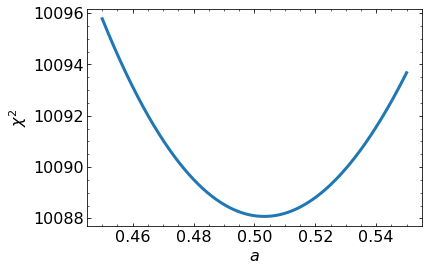

In [126]:
def chisquared_sigma_from_z(aguess):
    return np.sum(
        np.square(ynew - aguess * xnew) / (1. + aguess*aguess * np.abs(znew))
    )

avals_sigma_from_z = list(np.linspace(0.45,0.55,10000))
chisquaredvals_from_z = [chisquared_sigma_from_z(aval) for aval in avals_sigma_from_z]

besta = avals_sigma_from_z[np.argmin(chisquaredvals_from_z)]
print("Best a: {}".format(besta))
plt.plot(avals_sigma_from_z,chisquaredvals_from_z)
plt.xlabel(r'$a$')
plt.ylabel(r'$\chi^2$')

Now, with the sigma estimated from the true value of $z$, we get a much closer value. We find the standard deviations for the "wrong" and "right" chi squared values, by finding the range where $\chi^2 \leq \chi_{min}^2 + 1$:

In [128]:
within_std_dev_sigma_from_x = np.argwhere(chisquaredvals_sigma_from_x < np.min(chisquaredvals_sigma_from_x) + 1)
#print(within_std_dev_sigma_from_x[-1])
left_a_range_when_sigma_from_x = avals_sigma_from_x[within_std_dev_sigma_from_x[0][0]]
right_a_range_when_sigma_from_x = avals_sigma_from_x[within_std_dev_sigma_from_x[-1][0]]
a_sigma_when_using_x = (right_a_range_when_sigma_from_x - left_a_range_when_sigma_from_x) / 2
#range_sigma_from_x = (avals_sigma_from_x[within_std_dev_sigma_from_x[0]], avals_sigma_from_x[within_std_dev_sigma_from_x[-1]])
print("using xi to calculate measurement error:")
print("    chi-squared < {} + 1 from {} to {}".format(np.min(chisquaredvals_sigma_from_x), left_a_range_when_sigma_from_x, right_a_range_when_sigma_from_x))
print("    The standard deviation of best a {}".format(a_sigma_when_using_x))

within_std_dev_sigma_from_z = np.argwhere(chisquaredvals_from_z < np.min(chisquaredvals_from_z) + 1)
left_a_range_when_sigma_from_z = avals_sigma_from_z[within_std_dev_sigma_from_z[0][0]]
right_a_range_when_sigma_from_z = avals_sigma_from_z[within_std_dev_sigma_from_z[-1][0]]
a_sigma_when_using_z = (right_a_range_when_sigma_from_z - left_a_range_when_sigma_from_z) / 2
print("Using zi to calculate measurement error:")
print("    chi-squared < {} + 1 from {} to {}".format(np.min(chisquaredvals_from_z), left_a_range_when_sigma_from_z, right_a_range_when_sigma_from_z) )
print("    The standard deviation of best a is {}".format(a_sigma_when_using_z))

using xi to calculate measurement error:
    chi-squared < 6680.408197167923 + 1 from 56.743674367436746 to 104.44444444444446
    The standard deviation of best a 23.850385038503855
Using zi to calculate measurement error:
    chi-squared < 10088.074974901388 + 1 from 0.4838633863386339 to 0.5228072807280728
    The standard deviation of best a is 0.019471947194719452


When using $x_i$ to calculate measurement error, we are 73.5 away from $a_{real}=0.5$, or 3.1 standard deviations.  
When using $z_i$ to calculate measurement error, we are 0.00321 away from the $a_{real}=0.5$, or 0.16 standard deviations.

# Problem 2
## Part a)
We have a detector whose rate of detecting particles at a given time is  
$$R(t) = \frac{F_0}{\tau} \exp\left(-\frac{t-t_{SN}}{\tau}\right) \Theta\left(t-t_{SN}\right)$$  
We have detected events at different times, and if we split out timeline into bins of length $\Delta t$, then the expected number of events to occur in a timestep  $\Delta t$ at $t=t_i$ is, assuming $R$ changes little over the bin,  
$$\lambda_i = R(t_i)\Delta t$$  
The probabilities of detecting 0,1,2,etc particles during the timestep are 
$$ p\left(0\left|\lambda_i\right.\right) = e^{-\lambda_i} $$  
$$ p\left(1\left|\lambda_i\right.\right) =\lambda_i e^{-\lambda_i} $$  
$$ p\left(2\left|\lambda_i\right.\right) = \frac{\lambda_i^2}{2!}e^{-\lambda_i} $$  
And so on. The likelihood of getting the data we did get given a certain $\tau$, $F_0$, $t_{SN}$ is:  
$$\ell = \prod_i p\left(n_{detected,i}\left|\lambda_i\right.\right)$$
Since the detected events were each at different points, if we make our $\Delta t$ small enough, we only need to consider $p\left(0\left|\lambda_i\right.\right)$ and $p\left(1\left|\lambda_i\right.\right)$  
Then:  
$$\ell = \prod_i \left( \delta(detection) \lambda_i e^{-\lambda_i} + \delta(no\,detection) e^{-\lambda_i} \right)$$  
$$\ell = \prod_i  e^{-\lambda_i}\left( \lambda_i \delta(detection)  + \delta(no\,detection) \right)$$  
$$\log(\ell) = \log\left(\prod_i  e^{-\lambda_i}\left( \lambda_i \delta(detection)  + \delta(no\,detection) \right)\right) = \log\left(\prod_i  e^{-\lambda_i}\right) + \log\prod_i\left( \lambda_i \delta(detection)  + \delta(no\,detection) \right)$$  
In the second log product, terms where there is no detection just contribute a product of 1 to the $\prod$ product, so we can ignore those terms, and we just have the terms from the $N$ detected events:  
$$\log(\ell) = \log\left(\prod_i  e^{-\lambda_i}\right) + \log\prod_{event,i}\lambda_i$$  
So the likelihood is just a constant plus the log of the product of the $\lambda_i$ at each time where a particle was detected.  
  
Plugging in $\Delta t$ and $\lambda_i = R\left(t_i\right) \Delta t$,  
$$\log(\ell) = \sum_i\log\left( e^{-R\left(t_i\right)\Delta t}\right) + \log\prod_{i,event} R\left(t_i\right) \Delta t$$  
$$\log(\ell) = -\sum_i R\left(t_i\right)\Delta t + \log\Delta t^N + \sum_{i,event} \log  R\left(t_i\right)$$  

## Part b)

Taking the limit with $\Delta t \to 0$, the first sum becomes an integral, the $\log\Delta t^N$ becomes a very large negative that we can still ignore by renormalizing $\ell$ to $\tilde{\ell}$:
$$\log(\tilde{\ell}) = -\int R\left(t_i\right) dt + \sum_{i,event} \log  R\left(t_i\right)$$  

## Part c)
We can find maximum likelihood values of $F_0$, $\tau$ and $t_{SN}$ by differentiating the log of the likelihood:  
$$0 = \frac{\partial \log\tilde{\ell}}{\partial F_0} = -\int \frac{\partial R}{\partial F_0}  dt + \sum_{i,event} \frac{1}{R} \frac{\partial R}{\partial F_0}$$  

We differentiate $R\left(t,F_0,\tau,t_{SN}\right) = \frac{F_0}{\tau} \exp\left(-\frac{t-t_{SN}}{\tau}\right) \Theta\left(t-t_{SN}\right)$:  
$$ \frac{\partial R}{\partial F_0} = \frac{1}{\tau} \exp\left(-\frac{t-t_{SN}}{\tau}\right) \Theta\left(t-t_{SN}\right)$$  

Then,  
$$0 = \frac{\partial \log\tilde{\ell}}{\partial F_0} = - \int \frac{1}{\tau} \exp\left(-\frac{t-t_{SN}}{\tau}\right) \Theta\left(t-t_{SN}\right) dt +  \sum_{i,event}\frac{1}{R}\frac{R}{F_0}$$  
$$\frac{N_{detected}}{F_0} = \int_{t_{SN}}^\infty \frac{1}{\tau} \exp\left(-\frac{t-t_{SN}}{\tau}\right) dt $$  
$$\frac{N_{detected}}{F_0} = \int_{0}^\infty \frac{1}{\tau} e^{-t/\tau} dt = \left[-e^{-t/\tau}\right]_0^\infty = 1$  
$F_{0,best} = N_{detected}$$   

Differentiating to find best $\tau$:  
$$0 = \frac{\partial \log\tilde{\ell}}{\partial \tau} = -\int \frac{\partial R}{\partial \tau}  dt + \sum_{i,event} \frac{1}{R} \frac{\partial R}{\partial \tau}$$  

We differentiate $R\left(t,F_0,\tau,t_{SN}\right)$:  
$$ \frac{\partial R}{\partial \tau} = -\frac{F_0}{\tau^2} \exp\left(-\frac{t-t_{SN}}{\tau}\right) \Theta\left(t-t_{SN}\right) + \frac{F_0}{\tau} \left(\frac{t-t_{SN}}{\tau^2}\right) \exp\left(-\frac{t-t_{SN}}{\tau}\right) \Theta\left(t-t_{SN}\right) $$
$$ \frac{\partial R}{\partial \tau} = \left(\frac{t-t_{SN}}{\tau} - 1\right) \frac{F_0}{\tau^2}\exp\left(-\frac{t-t_{SN}}{\tau}\right) \Theta\left(t-t_{SN}\right) = \frac{1}{\tau} \left(\frac{t-t_{SN}}{\tau} - 1\right) R\left(t,F_0,\tau,t_{SN}\right)  $$  

So then,  
$$ 0 =  \frac{\partial \log\tilde{\ell}}{\partial \tau} = -\int \frac{\partial R}{\partial \tau}  dt + \sum_{i,event} \frac{1}{R} \frac{\partial R}{\partial \tau} =   \int_0^\infty \left(\frac{t-t_{SN}}{\tau} - 1\right) \frac{F_0}{\tau^2}\exp\left(-\frac{t-t_{SN}}{\tau}\right) \Theta\left(t-t_{SN}\right) dt + \sum_{i,event} \frac{1}{\tau} \left(\frac{t_i-t_{SN}}{\tau} - 1\right)  $$  
$$ 0 =  \int_0^\infty \left(\frac{t}{\tau} - 1\right) \frac{F_0}{\tau^2}\exp\left(-\frac{t}{\tau}\right) dt + \sum_{i,event} \frac{1}{\tau} \left(\frac{t_i-t_{SN}}{\tau} - 1\right)  $$  

We calculate the integral:  
$$ \int_0^\infty \left(\frac{t}{\tau} - 1\right) \frac{F_0}{\tau^2}\exp\left(-\frac{t}{\tau}\right) dt = \frac{F_0}{\tau^3} \int_0^\infty t\exp\left(-\frac{t}{\tau}\right) dt -  \frac{F_0}{\tau^2}\int_0^\infty\exp\left(-\frac{t}{\tau}\right) dt $$  
Using formulas $\int_0^\infty x e^{-a x} dx = 1/a^2$, and $\int_0^\infty e^{-a x} dx = 1/a$,  
$4 \int_0^\infty \left(\frac{t}{\tau} - 1\right) \frac{F_0}{\tau^2}\exp\left(-\frac{t}{\tau}\right) dt = \frac{F_0}{\tau^3} \tau^2 -  \frac{F_0}{\tau^2}\tau = 0 $$  

Substituting zero for the integral, we have  
$$ 0 = \sum_{i,event} \frac{1}{\tau} \left(\frac{t_i-t_{SN}}{\tau} - 1\right)  $$  
$$ 0 = \frac{1}{\tau^2}\sum_{i,event}\left(t_i-t_{SN}\right) - \frac{1}{\tau}N_{detected} $$  
$$ \frac{1}{\tau}\sum_{i,event}\left(t_i-t_{SN}\right) = N_{detected} $$   
$$ \tau_{best} = \frac{\sum_{i,event}\left(t_i-t_{SN}\right)}{N_{detected}} $$   

Differentiating to find best $t_{SN}$:  
$$0 = \frac{\partial \log\tilde{\ell}}{\partial t_{SN}} = -\frac{\partial}{\partial t_{SN}}\left( \int R  dt\right) + \sum_{i,event} \frac{1}{R} \frac{\partial R}{\partial t_{SN}}$$  

The integral $\int R dt$ is indendent of $t_{SN}$:  
$$\int R dt = \int \frac{F_0}{\tau} \exp\left(-\frac{t-t_{SN}}{\tau}\right) \Theta\left(t-t_{SN}\right) dt = \int_{t_{SN}}^\infty \frac{F_0}{\tau} \exp\left(-\frac{t-t_{SN}}{\tau}\right) dt =  \int_0^\infty \frac{F_0}{\tau} \exp\left(-\frac{t}{\tau}\right) dt$$  

This means that $\frac{\partial}{\partial t_{SN}}\left( \int R  dt\right) = 0$, so then we just have:  
$$0 = \frac{\partial \log\tilde{\ell}}{\partial t_{SN}} = \sum_{i,event} \frac{1}{R} \frac{\partial R}{\partial t_{SN}}$$  

Calculating $\frac{\partial R}{\partial t_{SN}}$, we can assume $\Theta\left(t-t_{SN}\right)=1$ since all neutrinos detected must happen after $t_{SN}$, events before $t_{SN}$ mean zero likelihood - they would have to come from some other source, and we're ignoring that possibility here. We differentiate $R=\frac{F_0}{\tau} \exp\left(-\frac{t-t_{SN}}{\tau}\right)$:  
$$\frac{\partial R}{\partial t_{SN}} = \frac{1}{\tau} \frac{F_0}{\tau} \exp\left(-\frac{t-t_{SN}}{\tau}\right) $$  

Then, we have  
$$0 = \frac{\partial \log\tilde{\ell}}{\partial t_{SN}} = \sum_{i,event} \frac{1}{R} \frac{\partial R}{\partial t_{SN}} = \sum_{i,event} \frac{1}{\frac{F_0}{\tau} \exp\left(-\frac{t-t_{SN}}{\tau}\right)} \frac{1}{\tau} \frac{F_0}{\tau} \exp\left(-\frac{t-t_{SN}}{\tau}\right) = \frac{N_{detected}}{\tau}$$  
It looks like the likelihood continually increases as $t_{SN}$ increases, so we can't solve for the best $t_{SN}$ by solving $\frac{\partial \log\tilde{\ell}}{\partial t_{SN}} = 0$. The best value of $t_{SN}$ then, is just the highest possible value allowed, which is the time that the first neutrino was detected (later times for the supernova don't make sense). It makes sense that the best fit model would put the supernova right at the time the first neutrino was detected, because the farther back we put $t_{SN}$, the less likely we are to see neutrinos at the measured times.  
So, $t_{SN,best} = t_1$, where $t_1$ is the time the first neutrino was detected.  


Substituting in $t_1$ for $t_{SN}$ in the $\tau_{best}$ formula, results are:  
$$F_{0,best} = N_{detected}$$
$$\tau_{best} = \frac{\sum_{i,event}\left(t_i-t_1\right)}{N_{detected}}$$
$$t_{SN,best} = t_1$$

## Part d)
First, we have to normalize the likelihood, with unnormalized likelihood given by:
$$\log(\tilde{\ell}) = -\int R\left(t_i\right) dt + \sum_{i,event} \log  R\left(t_i\right)$$
$$\log(\tilde{\ell}) = -F_0 + \sum_{i,event} \log  \left(\frac{F_0}{\tau}\exp\left(\frac{t_{SN}-t_i}{\tau}\right)\right)$$
$$\log(\tilde{\ell}) = -F_0 + N_{detected} \log\frac{F_0}{\tau} + \sum_{i,event} \left(\frac{t_{SN}-t_i}{\tau}\right)$$
$$\tilde{\ell} = e^{-F_0} \left(\frac{F_0}{\tau}\right)^{N_{detected}} \exp\left( \sum_{i,event} \left(\frac{t_{SN}-t_i}{\tau}\right)\right)$$

We can remove $F_0$ by integrating over $F_0$ from $0$ to $\infty$ with mathematica, plugging in our known $t_i$ values 0,0.1,0.15,0.3,0.5,0.9,1.55,1.7,3,5,7,9.15:
$$\tilde\ell\left(\tau,t_{SN}\right) = \int_0^\infty \tilde\ell dF_0 = \frac{4.79\times10^8}{\tau^{12}}e^{\frac{-29.35 + 12 \cdot t_{SN}}{\tau}} $$
If we integrate over $\tau$ from $0$ to $\infty$ and over $t_{SN}$ from $-\infty$ to $0$, we get
$$\int_0^\infty d\tau \int_{-\infty}^0 dt_{SN} \tilde\ell\left(\tau,t_{SN}\right) = 0.0305378$$
So, we normalize $\tilde\ell\left(\tau,t_{SN}\right)$ by dividing by $0.0305378$:
$$\ell_{normalized}\left(\tau,t_{SN}\right) = \frac{1.56855\times 10^{10}}{\tau^{12}}\exp\left(\left(-29.35+12 t_{SN}\right)/\tau\right)$$

In [81]:
from scipy.integrate import tplquad
import scipy.stats

def supernova_likelihood(tau,tsn):
    return (1.56855e10/tau**12)*np.exp((-29.35+12*tsn)/tau)

tsn_array = np.linspace(-2,-0.00001 , 3000)
tau_array = np.linspace(0.00001, 10, 3000)

delta_tsn = tsn_array[1]-tsn_array[0]
delta_tau = tau_array[1]-tau_array[0]
tau_mesh,tsn_mesh = np.meshgrid(tau_array,tsn_array)

#d_tsn = 0.02
#d_tau = 0.02
#vals_tsn = np.arange(-100,0,d_tsn)
#vals_tau = np.arange(0.0001,100,d_tau)

#X,Y=np.meshgrid(vals_tsn,vals_tau)

likelihoods = supernova_likelihood(tau_mesh,tsn_mesh)

So, we now have the likelihood as a function of $\tau$ and $t_{SN}$. First we try making contours for $1\sigma$,$2\sigma$,$3\sigma$ with the assumption that we can use $\Delta \chi^2 = -2\ln\ell$, with values calculated from the $\Delta \chi^2$ that we can calculate for the different deviations (assuming normal independent parameters).  
We graph the contours at $1\sigma$,$2\sigma$,$3\sigma$:

Likelihoods for 3 sigma, 2 sigma, 1 sigma:
[0.0027394448187683684, 0.04550195440462157, 0.3166367693790533]


Text(0, 0.5, '$t_{SN}$')

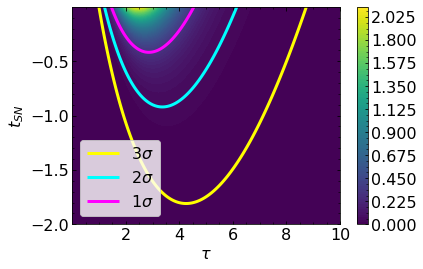

In [130]:

deltachisquared_sigma321=[11.8,6.18,2.3]
sigma321_likelihoods = [np.exp(-dc/2) for dc in deltachisquared_sigma321]
print("Likelihoods for 3 sigma, 2 sigma, 1 sigma:")
print(sigma321_likelihoods)

chisq_contourf = plt.contourf(tau_mesh,tsn_mesh,likelihoods,levels=100)

cbar_contourf = plt.colorbar(chisq_contourf)
ct_chisq = plt.contour(tau_mesh,tsn_mesh,likelihoods,levels=sigma321_likelihoods,colors=["yellow","cyan","magenta"])
fmt_chisq={}
strs_chisq=[r'3$\sigma$',r'2$\sigma$',r'1$\sigma$']
for i, label in enumerate(strs_chisq):
    ct_chisq.collections[i].set_label(label)
    fmt_chisq[l] = s
plt.legend(loc = "lower left")
#plt.clabel(ct_chisq,sigma321_likelihoods,fmt=fmt_chisq,fontsize=8)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$t_{SN}$')

Now, we find out what the actual contours containing $68\%$,$95\%$, and $99.7\%$ of the likelihood are. We find the proportion of integrated likelihood within a given contour L, and then we solve for the L values that contain $68\%$,$95\%$, and $99.7\%$ of the integrated likelihood. 

In [106]:
from scipy import interpolate

# So we get accurate likelihoods contained even for small values of L,

# we integrate over a larger space of less probable measurements
expanded_tsn_array = np.arange(-4,-0.00001 , delta_tsn)
expanded_tau_array = np.arange(0.00001, 20, delta_tau)

expanded_tau_mesh,expanded_tsn_mesh = np.meshgrid(expanded_tau_array,expanded_tsn_array)
expanded_likelihoods = supernova_likelihood(expanded_tau_mesh,expanded_tsn_mesh)
# Probability of likelihood being greater than a given value
def likelihood_contained(L):
    return np.sum(expanded_likelihoods * (expanded_likelihoods > L)) * delta_tsn * delta_tau

lvals = np.arange(0,2.5,0.01)
qvals = [likelihood_contained(lval) for lval in lvals]

# We interpolate for find the likelihood contour value as a function of likelihood contained inside.
interpolated_l_of_q = interpolate.interp1d(qvals,lvals)

Likelihoods for 99.7,95,68 percent contained:
[array(0.00140568), array(0.02027862), array(0.25831825)]


Text(0, 0.5, '$t_{SN}$')

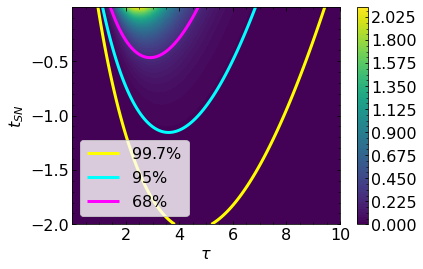

In [131]:
percentages = [0.997,0.95,0.68]
pc_likelihoods = [interpolated_l_of_q(pc) for pc in percentages]
print("Likelihoods for 99.7,95,68 percent contained:")
print(pc_likelihoods)
# print(interpolated_l_of_q(0.5))
# print("Likelihoods: {}".format(pc_likelihoods))
# for lik in pc_likelihoods:
#     print(lik)

pc_contourf = plt.contourf(tau_mesh,tsn_mesh,likelihoods,levels=100)
cbar_pc = plt.colorbar(pc_contourf)

ct_pc = plt.contour(tau_mesh,tsn_mesh,likelihoods,levels=pc_likelihoods,colors=["yellow","cyan","magenta"])

strs_pc=[r'$99.7\%$',r'$95\%$',r'$68\%$']
for i, label in enumerate(strs_pc):
    ct_pc.collections[i].set_label(label)
plt.legend(loc = "lower left")
plt.xlabel(r'$\tau$')
plt.ylabel(r'$t_{SN}$')


So, we see that the contours are actually different, it turns out the naive assumption of normally distributed and independent errors for our parameters underestimates error. The true contours for $68\%$,$95\%$,$99.7\%$ actually contain larger areas of parameter space. We should use the contours calculated from integrating our likelihood, since these are more reliable in describing our model than the $\chi^2$ method, which makes assumptions about error distributions that do not apply to our likelihood, which is very asymmetric in its parameters.

## Part e)
To find the probability distribution of $t_{SN}$ marginalizeing over $F_0$ and $\tau$, assuming uniform priors, all we need to do is integrate the likelihood over $F_0$ and $\tau$. Because the prior $P(F_0,\tau,t_{SN}$ is uniform, it doesn't factor into the integral over parameter space:
$$ P\left(model\left|data\right.\right) = \frac{\ell \cdot prior}{\left\Vert \ell \right\Vert}$$
With $\ell$ already normalized and the prior being uniform:
$$ P\left(t_{SN}\right) = \int_0^\infty d\tau \int_0^\infty dF_0 \ell\left(F_0,\tau,t_{SN}\right)  $$
Integrating with Wolfram Mathematica gives us:
$$ P\left(t_{SN}\right) = \frac{76607.}{\left(2.44583 - t_{SN}\right)^{11}} $$  

We can plot $P\left(t_{SN}\right)$, considering only negative values since the supernova time cannot be after the first measured neutrino.

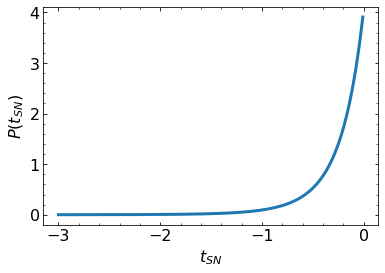

In [132]:
def prob_tsn(tsn_v):
    return 76607/np.power(2.44583 - tsn_v,11)

x_tsn = np.arange(-3,0,0.01)
y_prob = prob_tsn(x_tsn)
plt.plot(x_tsn,y_prob)
plt.xlabel(r'$t_{SN}$')
lab = plt.ylabel(r'$P\left(t_{SN}\right)$')
